In [1]:
# 1) Imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Load dataset (change path)
df = pd.read_csv("marketing_campaign.csv", sep='\t')
print("Data shape:", df.shape)
df.head()

Data shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# 2) Preprocess: numeric selection, imputation, scaling
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

X = df[numeric_cols].copy()

# Impute missing values (median)
imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)


Numeric columns: ['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


      PC  ExplainedVariance  ExplainedVarianceRatio  CumulativeVarianceRatio
0    PC1             6.5182                  0.2715                   0.2715
1    PC2             2.0249                  0.0843                   0.3558
2    PC3             1.8970                  0.0790                   0.4348
3    PC4             1.4079                  0.0586                   0.4934
4    PC5             1.1124                  0.0463                   0.5398
5    PC6             1.0377                  0.0432                   0.5830
6    PC7             1.0169                  0.0424                   0.6253
7    PC8             0.9387                  0.0391                   0.6644
8    PC9             0.8576                  0.0357                   0.7002
9   PC10             0.7607                  0.0317                   0.7318
10  PC11             0.7451                  0.0310                   0.7629
11  PC12             0.6622                  0.0276                   0.7904

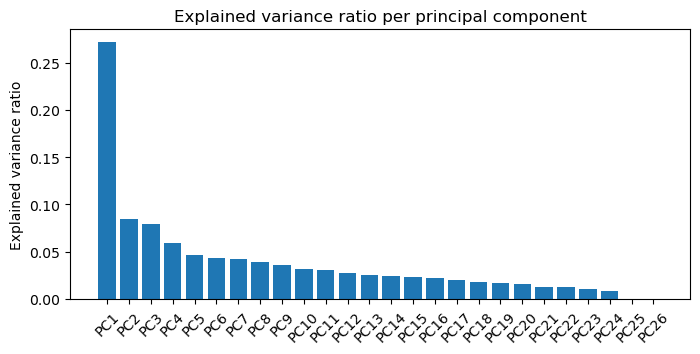

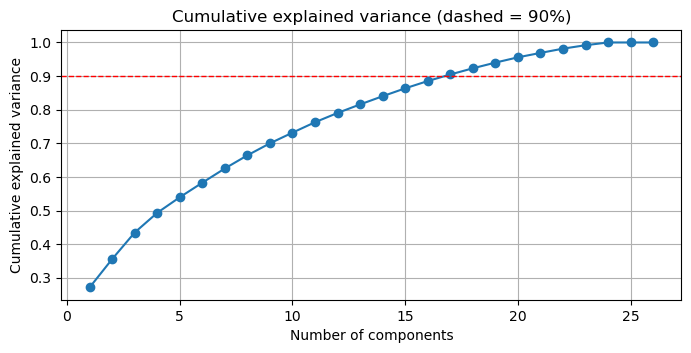

Components to retain 70% variance: 9


In [4]:
# 3) PCA: fit full PCA and show explained variance
pca_full = PCA()      # keep all components
pca_full.fit(X_scaled)

explained_var = pca_full.explained_variance_
explained_var_ratio = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained_var_ratio)

ev_df = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained_var_ratio))],
    "ExplainedVariance": explained_var,
    "ExplainedVarianceRatio": explained_var_ratio,
    "CumulativeVarianceRatio": cumulative
})
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
print(ev_df)

# Plots: explained ratio (bar) and cumulative (line)
plt.figure(figsize=(8,3.5))
plt.bar(ev_df["PC"], ev_df["ExplainedVarianceRatio"])
plt.ylabel("Explained variance ratio")
plt.title("Explained variance ratio per principal component")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,3.5))
plt.plot(range(1,len(cumulative)+1), cumulative, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.axhline(0.90, color="r", linestyle="--", linewidth=1)  # 90% guideline
plt.title("Cumulative explained variance (dashed = 90%)")
plt.grid(True)
plt.show()

# Automatically choose number of components to retain a threshold (e.g., 70%)
threshold = 0.70
n_components = int(np.searchsorted(cumulative, threshold) + 1)
print(f"Components to retain {threshold*100:.0f}% variance: {n_components}")

In [5]:
# 4) Create PCA-transformed dataset for clustering
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA shape:", X_pca.shape)   # (n_samples, n_components)

PCA shape: (2240, 9)


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

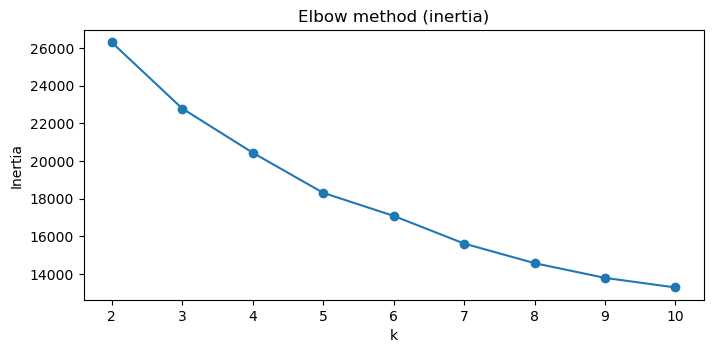

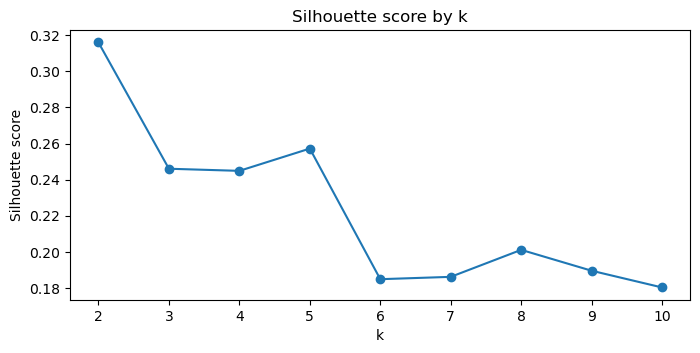

Optimal k by max silhouette: 2


In [6]:
# 5) Find optimal k using inertia and silhouette score
k_range = range(2, 11)
inertias = []
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))

# Plot inertia (elbow)
plt.figure(figsize=(8,3.5))
plt.plot(k_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method (inertia)")
plt.xticks(k_range)
plt.show()

# Plot silhouette
plt.figure(figsize=(8,3.5))
plt.plot(k_range, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score by k")
plt.xticks(k_range)
plt.show()

# Auto-pick k by max silhouette (you can override after visual inspection)
optimal_k = k_range[int(np.argmax(sil_scores))]
print("Optimal k by max silhouette:", optimal_k)


In [7]:
# 6) Final KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)
df["Cluster"] = labels

# Cluster centers in PCA space and approximate centers back in original feature space
centers_pca = kmeans.cluster_centers_
centers_original_approx = scaler.inverse_transform(pca.inverse_transform(centers_pca))
centers_df = pd.DataFrame(centers_original_approx, columns=X.columns)
print("Approx cluster centers (original feature scale):")
display(centers_df.round(3))


Approx cluster centers (original feature scale):


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5579.2770,1969.9330,39209.7540,0.7020,0.5580,48.8630,120.7640,6.2500,41.2690,9.2090,...,6.4090,0.0680,0.0360,-0.0060,0.0000,0.0010,0.0100,3.0000,11.0000,0.0960
1,5612.0320,1967.0660,72334.8580,0.0470,0.4260,49.4890,586.4900,57.2340,360.8210,81.2060,...,3.6310,0.0800,0.1350,0.1940,0.1630,0.0320,0.0080,3.0000,11.0000,0.2310


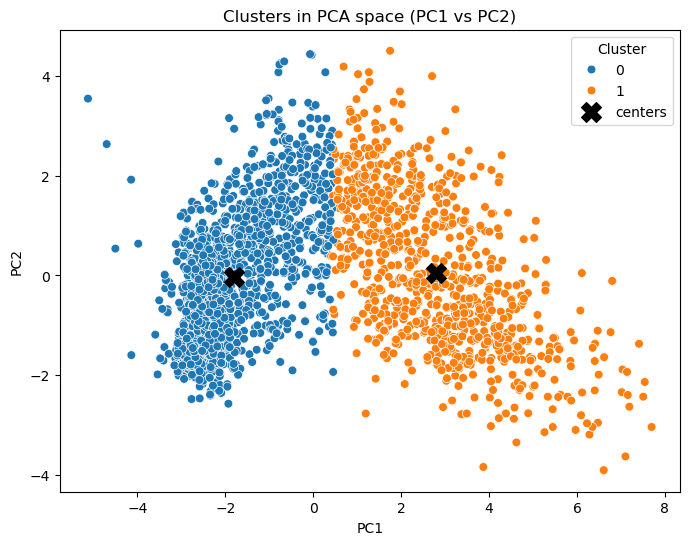

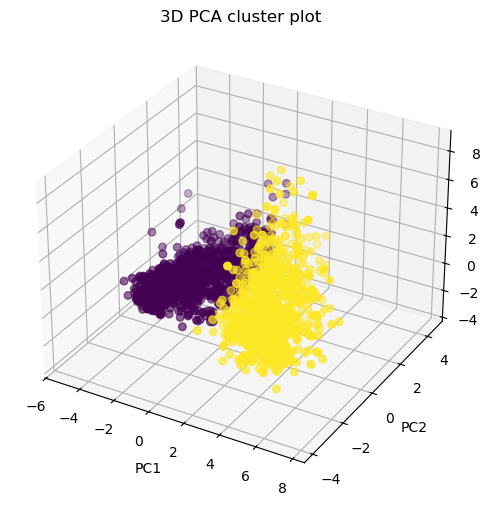

In [8]:
# 7) 2D scatter (first 2 PCs)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette="tab10", s=40, legend="full")
plt.scatter(centers_pca[:,0], centers_pca[:,1], c="black", marker="X", s=200, label="centers")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Clusters in PCA space (PC1 vs PC2)")
plt.legend(title="Cluster")
plt.show()

# 3D plot if we have at least 3 PCs
if X_pca.shape[1] >= 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels, s=30)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    plt.title("3D PCA cluster plot")
    plt.show()


In [9]:
# 8) Profiling: counts & descriptive stats on original numeric features
cluster_counts = df["Cluster"].value_counts().sort_index()
cluster_props = (cluster_counts / len(df)).round(3)
print("Counts per cluster:\n", cluster_counts)
print("Proportions:\n", cluster_props)

# Detailed profile: mean/median/std for numeric features by cluster
profile = df.groupby("Cluster")[X.columns].agg(["mean","median","std"]).round(3)
display(profile)

# Top differentiating features per cluster (relative to global mean)
global_mean = X_imp.mean()
cluster_means = df.groupby("Cluster")[X.columns].mean()
delta_pct = ((cluster_means - global_mean) / global_mean.replace(0, np.nan)).fillna(0)
top_features = {c: delta_pct.loc[c].sort_values(ascending=False).head(5).index.tolist()
                for c in delta_pct.index}
print("Top 5 positively different features per cluster (vs global mean):")
for c, feats in top_features.items():
    print(f" Cluster {c}: {feats}")



Counts per cluster:
 Cluster
0    1359
1     881
Name: count, dtype: int64
Proportions:
 Cluster
0   0.6070
1   0.3930
Name: count, dtype: float64


ID                     Year_Birth                       Income  \
             mean    median       std       mean    median     std       mean   
Cluster                                                                         
0       5583.6210 5455.0000 3254.3840  1969.9330 1971.0000 11.5330 39174.5410   
1       5605.3310 5462.0000 3236.5170  1967.0670 1967.0000 12.4560 72357.9610   

                              Kidhome  ... Complain Z_CostContact         \
            median        std    mean  ...      std          mean median   
Cluster                                ...                                 
0       38557.0000 15432.8130  0.6890  ...   0.1010        3.0000 3.0000   
1       71691.0000 23979.0020  0.0670  ...   0.0890        3.0000 3.0000   

               Z_Revenue                Response                
           std      mean  median    std     mean median    std  
Cluster                                                         
0       0.0000   11.0000 11.0000 0.0000   0.0940 0.0000 0.2920  
1       0.0000   11.0000 11.0000 0.0000   0.2340 0.0000 0.4240  

[2 rows x 78 columns]

Top 5 positively different features per cluster (vs global mean):
 Cluster 0: ['Kidhome', 'NumWebVisitsMonth', 'Teenhome', 'Complain', 'NumDealsPurchases']
 Cluster 1: ['AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'MntMeatProducts', 'MntSweetProducts']


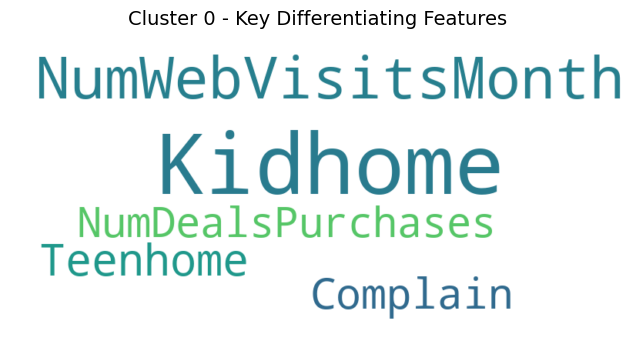

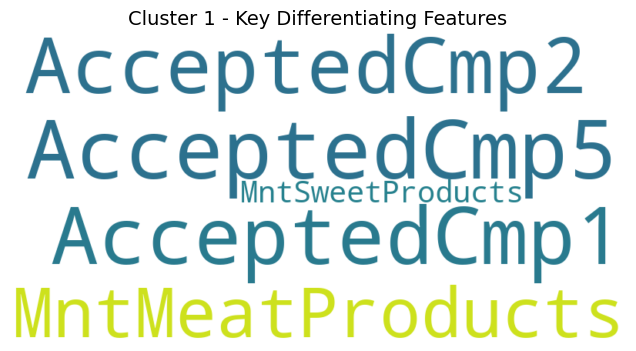

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate separate word clouds for each cluster
for cluster, features in top_features.items():
    # Scale word sizes by delta percentages (so more distinct features appear bigger)
    freqs = delta_pct.loc[cluster, features].to_dict()
    
    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis")
    wc.generate_from_frequencies(freqs)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"Cluster {cluster} - Key Differentiating Features", fontsize=14)
    plt.axis("off")
    plt.show()
